In [1]:
import pandas as pd
import numpy as np
import math
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore

dict_dayofweek = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

In [2]:
df_biketrips = pd.read_csv('biketrips2011.csv')
df_biketrips['StartTime'] = df_biketrips['StartTime'].astype('datetime64')
df_biketrips['EndTime'] = df_biketrips['EndTime'].astype('datetime64')
df_biketrips['StartNum'] = df_biketrips['StartNum'].astype(int)
df_biketrips['EndNum'] = df_biketrips['EndNum'].astype(int)

In [3]:
# new features - to help group by hour
df_dhcombo_out = pd.DataFrame({
    'Day': df_biketrips['StartTime'].dt.date,
    'Hour': df_biketrips['StartTime'].dt.hour,
})

df_dhcombo_in = pd.DataFrame({
    'Day': df_biketrips['EndTime'].dt.date,
    'Hour': df_biketrips['EndTime'].dt.hour,
})

df_biketrips['StartHour'] = pd.to_datetime(df_dhcombo_out.Day) + pd.to_timedelta(df_dhcombo_out.Hour, unit='h')
df_biketrips['EndHour'] = pd.to_datetime(df_dhcombo_in.Day) + pd.to_timedelta(df_dhcombo_in.Hour, unit='h')

In [4]:
# create pivot tables, with each site as a column
df_hourly_start = df_biketrips.pivot_table(values='count',index='StartHour',columns='StartNum',aggfunc='sum',fill_value=None)
df_hourly_end = df_biketrips.pivot_table(values='count',index='EndHour',columns='EndNum',aggfunc='sum',fill_value=None)

In [5]:
# insert rows for missing hours
from datetime import datetime, timedelta

def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta

start_date = df_hourly_start.index[0]
end_date = df_hourly_start.index[-1]
#print(daterange(start_date, end_date))
idx_datetime = []
for single_date in daterange(start_date, end_date):
    idx_datetime.append(single_date.strftime("%Y-%m-%d %H:%M:%S"))

df_hourly_start = df_hourly_start.reindex(pd.DatetimeIndex(idx_datetime))
df_hourly_end = df_hourly_end.reindex(pd.DatetimeIndex(idx_datetime))

In [6]:
df_hourly_start['hourofday'] = df_hourly_start.index.hour
df_hourly_start['dayofweek'] = df_hourly_start.index.dayofweek

df_hourly_end['hourofday'] = df_hourly_end.index.hour
df_hourly_end['dayofweek'] = df_hourly_end.index.dayofweek

df_hourly_start['weekofyear'] = df_hourly_start.index.weekofyear
df_hourly_end['weekofyear'] = df_hourly_end.index.weekofyear

In [7]:
# take off last 3 columns (added features above)
sites = df_hourly_start.columns[0:len(df_hourly_start.columns)-3]

In [8]:
#sample_sites = [31007,31015,31103,31104,31200,31201,31217,31219,31623]
#31007 and 31015 are low volume
sample_sites = [31007,31100,31103,31200,31215]

In [9]:
def anomalyDetection(p_site,p_dayofweek,p_hourofday,p_weekofyear):

    df_test_start = df_hourly_start[(df_hourly_start['dayofweek']==p_dayofweek)&(df_hourly_start['hourofday']==p_hourofday)][p_weekofyear:(p_weekofyear+30)].fillna(0)
    df_test_end = df_hourly_end[(df_hourly_end['dayofweek']==p_dayofweek)&(df_hourly_end['hourofday']==p_hourofday)][p_weekofyear:(p_weekofyear+30)].fillna(0)

    est_start = LocalOutlierFactor(n_neighbors=20,contamination=0.2)
    est_end = LocalOutlierFactor(n_neighbors=20,contamination=0.2)
    
    X_start = df_test_start[p_site].fillna(0)
    X_start_idx = X_start.index
    X_start_reshape = X_start.values.reshape(-1,1)
    est_start.fit(X_start_reshape)    

    X_end = df_test_end[p_site].fillna(0)
    X_end_idx = X_end.index
    X_end_reshape = X_end.values.reshape(-1,1)
    est_end.fit(X_end_reshape)  
    
    outlier_factor_start = est_start.negative_outlier_factor_ * -1
    outlier_factor_end = est_end.negative_outlier_factor_ * -1       

    zscore_lof_start = zscore(outlier_factor_start)
    zscore_lof_end = zscore(outlier_factor_end) 
    
    # only trigger an alert if the high count is 8 or more, or is low count
    alert_start =  (zscore_lof_start>2) & (((X_start>=8)&(X_start>X_start.mean()))^(X_start<X_start.mean()))
    alert_end =  (zscore_lof_end>2) & (((X_end>=8)&(X_end>X_end.mean()))^(X_end<X_end.mean()))
    
    df_test = pd.DataFrame(list(zip(X_start_idx,X_start,X_end,outlier_factor_start,outlier_factor_end,zscore_lof_start,zscore_lof_end,alert_start,alert_end)),columns=['datetime','cnt_strt','cnt_end','lof_strt','lof_end','zscore_strt','zscore_end','alert_strt','alert_end'])
    return df_test

In [10]:
# df_results - expected DF input
# 1) cnt_strt
# 2) cnt_end
# 3) alert_strt
# 4) alert_end
def plot_sequence(df_results,sitenum,dayofweek,hourofday,startweek):
    df_plot = df_results
    
    df_plot['outlier'] = df_plot['alert_strt'] + df_plot['alert_end']
    markers = ['o','x'][0:len(np.unique(df_plot['outlier']))]
    sns.lmplot(x='cnt_strt',y='cnt_end',hue='outlier',data=df_plot,fit_reg=False,markers=markers)
    str_title = 'Site: ' + str(sitenum) + ', Day: ' + dict_dayofweek.get(dayofweek) + ', Hour: ' + str(hourofday) + ', Start Week: ' + str(startweek)
    plt.title(str_title)
    plt.xlabel('Departures')
    plt.ylabel('Arrivals')

    plt.show()

In [11]:
#get a random:
# - site (see temp_sites)
# - day of week (0 to 6)
# - hour of day (0 to 23)
# - window (week 0 to 21 - to get to end of year)

temp_sites = [31200,31201,31623,31101,31237,31602,31238,31503]
list_test = []
for i in np.arange(0,1000):
    rand_site = temp_sites[randint(0,len(temp_sites)-1)]
    rand_d = randint(0,6)
    rand_h = randint(0,23)
    rand_w = randint(0,21)
    
    df_test = anomalyDetection(rand_site,rand_d,rand_h,rand_w)
    df_test['test_num'] = i
    df_test['sitenum'] = rand_site
    df_test['dayofweek'] = rand_d
    df_test['hourofday'] = rand_h
    df_test['startweek'] = rand_w
    list_test.append(df_test)

df_results = pd.concat(list_test)
df_results.reset_index(inplace=True)
df_results.set_index(['test_num','index'],inplace=True)
df_results.to_excel('testresults.xlsx')

/Users/Derek/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/Users/Derek/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in greater
/Users/Derek/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater


In [20]:
count_outlier_start = len(df_results[df_results['alert_strt']==True])
count_outlier_end = len(df_results[df_results['alert_end']==True])
count_all = len(df_results)

print('Anomalous starts:',count_outlier_start)
print('Percentage of anomalous starts:',count_outlier_start/count_all*100,'%')
print('Anomalous ends:',count_outlier_end)
print('Total datapoints:',count_all)
print('Percentage of anomalous ends:',count_outlier_end/count_all*100,'%')

Anomalous starts: 853
Percentage of anomalous starts: 2.8433333333333333 %
Anomalous ends: 846
Total datapoints: 30000
Percentage of anomalous ends: 2.82 %


<h3>Afternoon Rush Hour</h3>
<p>Note there are outliers in trips starting at this location on both the low and high end.</p>

/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


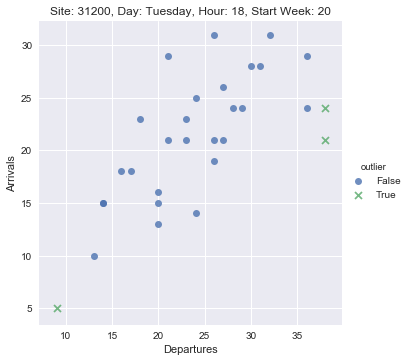

,datetime,cnt_strt,cnt_end,alert_strt,alert_end
0,2011-05-24 18:00:00,27.0,26.0,False,False
1,2011-05-31 18:00:00,20.0,16.0,False,False
2,2011-06-07 18:00:00,38.0,21.0,True,False
3,2011-06-14 18:00:00,29.0,24.0,False,False
4,2011-06-21 18:00:00,26.0,21.0,False,False
5,2011-06-28 18:00:00,36.0,24.0,False,False
6,2011-07-05 18:00:00,27.0,21.0,False,False
7,2011-07-12 18:00:00,24.0,25.0,False,False
8,2011-07-19 18:00:00,30.0,28.0,False,False
9,2011-07-26 18:00:00,17.0,18.0,False,False


In [14]:
df_demo = anomalyDetection(31200,1,18,20)
plot_sequence(df_demo,31200,1,18,20)
df_demo[['datetime','cnt_strt','cnt_end','alert_strt','alert_end']]

<h3>Morning Rush Hour</h3>
<p>Note there are outliers in trips starting at this location on both the low and high end.</p>

/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


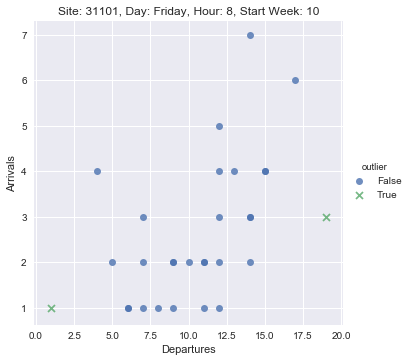

,datetime,cnt_strt,cnt_end,alert_strt,alert_end
0,2011-03-18 08:00:00,9.0,2.0,False,False
1,2011-03-25 08:00:00,7.0,2.0,False,False
2,2011-04-01 08:00:00,6.0,1.0,False,False
3,2011-04-08 08:00:00,8.0,1.0,False,False
4,2011-04-15 08:00:00,14.0,3.0,False,False
5,2011-04-22 08:00:00,15.0,4.0,False,False
6,2011-04-29 08:00:00,15.0,4.0,False,False
7,2011-05-06 08:00:00,14.0,3.0,False,False
8,2011-05-13 08:00:00,10.0,2.0,False,False
9,2011-05-20 08:00:00,19.0,3.0,True,False


In [15]:
df_demo = anomalyDetection(31101,4,8,10)
plot_sequence(df_demo,31101,4,8,10)
df_demo[['datetime','cnt_strt','cnt_end','alert_strt','alert_end']]

<h3>Weekday Mid-day</h3>

/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


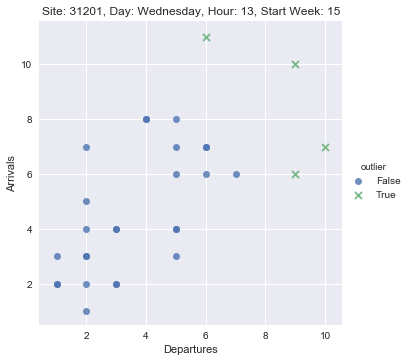

,datetime,cnt_strt,cnt_end,alert_strt,alert_end
0,2011-04-20 13:00:00,3.0,4.0,False,False
1,2011-04-27 13:00:00,6.0,7.0,False,False
2,2011-05-04 13:00:00,5.0,3.0,False,False
3,2011-05-11 13:00:00,3.0,2.0,False,False
4,2011-05-18 13:00:00,1.0,3.0,False,False
5,2011-05-25 13:00:00,6.0,11.0,False,True
6,2011-06-01 13:00:00,2.0,3.0,False,False
7,2011-06-08 13:00:00,6.0,7.0,False,False
8,2011-06-15 13:00:00,5.0,4.0,False,False
9,2011-06-22 13:00:00,2.0,4.0,False,False


In [16]:
df_demo = anomalyDetection(31201,2,13,15)
plot_sequence(df_demo,31201,2,13,15)
df_demo[['datetime','cnt_strt','cnt_end','alert_strt','alert_end']]

<h3>Weekday Evening</h3>
<p>The higher counts in the trips ending (7) does not reach the minimum threshold of 8 set in the anomaly detection system</p>

/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


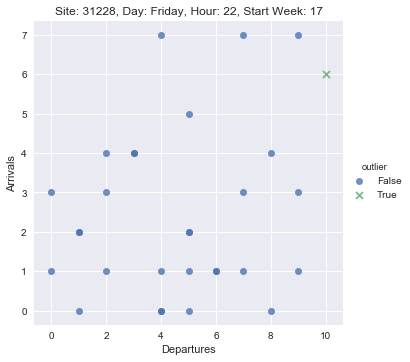

,datetime,cnt_strt,cnt_end,alert_strt,alert_end
0,2011-05-06 22:00:00,7.0,1.0,False,False
1,2011-05-13 22:00:00,3.0,4.0,False,False
2,2011-05-20 22:00:00,7.0,7.0,False,False
3,2011-05-27 22:00:00,5.0,5.0,False,False
4,2011-06-03 22:00:00,6.0,1.0,False,False
5,2011-06-10 22:00:00,5.0,2.0,False,False
6,2011-06-17 22:00:00,4.0,7.0,False,False
7,2011-06-24 22:00:00,9.0,3.0,False,False
8,2011-07-01 22:00:00,9.0,7.0,False,False
9,2011-07-08 22:00:00,9.0,1.0,False,False


In [17]:
df_demo = anomalyDetection(31228,4,22,17)
plot_sequence(df_demo,31228,4,22,17)
df_demo[['datetime','cnt_strt','cnt_end','alert_strt','alert_end']]

<h3>Weekend Mid-day</h3>
<p>There is one clear outlier.</p>

/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


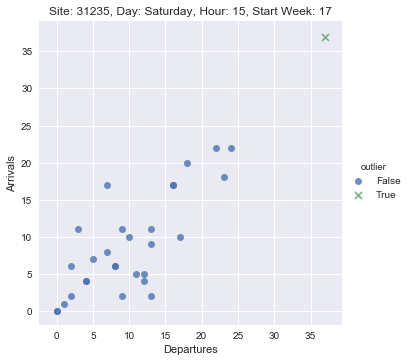

,datetime,cnt_strt,cnt_end,alert_strt,alert_end
0,2011-04-30 15:00:00,23.0,18.0,False,False
1,2011-05-07 15:00:00,4.0,4.0,False,False
2,2011-05-14 15:00:00,2.0,2.0,False,False
3,2011-05-21 15:00:00,12.0,4.0,False,False
4,2011-05-28 15:00:00,10.0,10.0,False,False
5,2011-06-04 15:00:00,2.0,6.0,False,False
6,2011-06-11 15:00:00,9.0,11.0,False,False
7,2011-06-18 15:00:00,8.0,6.0,False,False
8,2011-06-25 15:00:00,12.0,5.0,False,False
9,2011-07-02 15:00:00,4.0,4.0,False,False


In [18]:
df_demo = anomalyDetection(31235,5,15,17)
plot_sequence(df_demo,31235,5,15,17)
df_demo[['datetime','cnt_strt','cnt_end','alert_strt','alert_end']]

<h3>Overnight</h3>
<p>Note not outliers, since none of these counts reach the minimum threshold of 8</p>

/Users/Derek/anaconda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


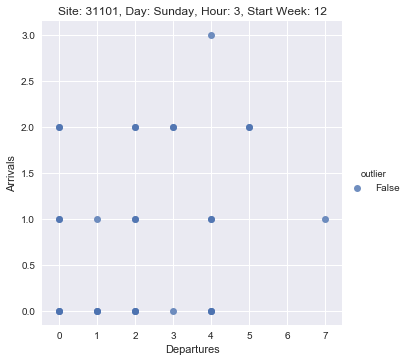

,datetime,cnt_strt,cnt_end,alert_strt,alert_end
0,2011-03-27 03:00:00,1.0,0.0,False,False
1,2011-04-03 03:00:00,3.0,0.0,False,False
2,2011-04-10 03:00:00,4.0,1.0,False,False
3,2011-04-17 03:00:00,0.0,2.0,False,False
4,2011-04-24 03:00:00,2.0,0.0,False,False
5,2011-05-01 03:00:00,0.0,0.0,False,False
6,2011-05-08 03:00:00,0.0,1.0,False,False
7,2011-05-15 03:00:00,4.0,0.0,False,False
8,2011-05-22 03:00:00,3.0,2.0,False,False
9,2011-05-29 03:00:00,2.0,0.0,False,False


In [19]:
df_demo = anomalyDetection(31101,6,3,12)
plot_sequence(df_demo,31101,6,3,12)
df_demo[['datetime','cnt_strt','cnt_end','alert_strt','alert_end']]